# Get ids

In [1]:
import pandas as pd
from Bio import Entrez
Entrez.email = "diegocar@lcg.unam.mx"
Entrez.apikey = "34677fdcfd2f0659a7f9ee05ab6e44704f09"
from random import choices

In [2]:
data = pd.read_csv("../results/2310_Oct/231027GSMsMeta/01/metadata_00.tsv", sep='\t')

In [154]:
def get_org_id(org, tries=10):
    try:
        with Entrez.esearch(db="taxonomy", term=org) as handle:
            record = Entrez.read(handle)
    except:
        if tries: return(get_org_id(org, tries -1))
        print(f"Error: {org}")
        return("None")
    return(record['IdList'][0])

def get_taxid_lineage(txid, i, m, tries = 10):
    print(f"Consulting id {i}/{m}")
    try:
        with Entrez.efetch(db="taxonomy", id=txid) as handle:
            record = Entrez.read(handle)
        temp = {"TaxId": txid}
        temp.update({d["Rank"] : d["ScientificName"] for d in record[0]["LineageEx"]})
        return(temp)
    except:
        if tries: return(get_taxid_lineage(txid, i, m , tries -1))
        print(f"Error: {txid}")
        return({})
    

In [73]:
a = [get_org_id(org) for org in ["Homo sapiens", "Escherichia coli", "Zea mays"] ]
b = [get_taxid_lineage(uid, i, len(a)) for i,uid in enumerate(a)]
pd.DataFrame.from_dict(b)

Consulting id 0/3
Consulting id 1/3
Consulting id 2/3


,TaxId,no rank,superkingdom,clade,kingdom,phylum,subphylum,superclass,class,superorder,...,suborder,infraorder,parvorder,superfamily,family,subfamily,genus,subclass,tribe,subtribe
0,9606,cellular organisms,Eukaryota,Boreoeutheria,Metazoa,Chordata,Craniata,Sarcopterygii,Mammalia,Euarchontoglires,...,Haplorrhini,Simiiformes,Catarrhini,Hominoidea,Hominidae,Homininae,Homo,NaN,NaN,NaN
1,562,cellular organisms,Bacteria,NaN,NaN,Pseudomonadota,NaN,NaN,Gammaproteobacteria,NaN,...,NaN,NaN,NaN,NaN,Enterobacteriaceae,NaN,Escherichia,NaN,NaN,NaN
2,4577,Andropogonodae,Eukaryota,PACMAD clade,Viridiplantae,Streptophyta,Streptophytina,NaN,Magnoliopsida,NaN,...,NaN,NaN,NaN,NaN,Poaceae,Panicoideae,Zea,Petrosaviidae,Andropogoneae,Tripsacinae


In [58]:
with Entrez.efetch(db="taxonomy", id='562') as handle:
     record = Entrez.read(handle)

In [155]:
a = get_taxid_lineage(511145, 1, 2)
a

Consulting id 1/2


{'TaxId': 511145,
 'no rank': 'cellular organisms',
 'superkingdom': 'Bacteria',
 'phylum': 'Pseudomonadota',
 'class': 'Gammaproteobacteria',
 'order': 'Enterobacterales',
 'family': 'Enterobacteriaceae',
 'genus': 'Escherichia',
 'species': 'Escherichia coli',
 'strain': 'Escherichia coli K-12'}

# Merge all GEO data!


In [2]:
import pandas as pd
from Bio import Entrez
Entrez.email = "diegocar@lcg.unam.mx"
Entrez.apikey = "34677fdcfd2f0659a7f9ee05ab6e44704f09"
from re import sub

In [4]:
# GEO entities
gses = pd.read_csv("../../results/2310_Oct/231018GEOmetadata/esummary_metadata_2.tsv", sep="\t", index_col="Unnamed: 0")
gpls = pd.read_csv("../../results/2310_Oct/231020GPL/gpl_metadata.tsv", sep="\t", index_col="Unnamed: 0")
gsms = pd.read_csv("../../data/GEOData/allGSMsMetadata.tsv", sep="\t").drop_duplicates() # Headers were duplicated
gsms = gsms.drop(88321, axis=0).reset_index().drop(["index", "Unnamed: 0"], axis=1) # Delete header row and Unnamed column

# Taxonomy
species_id = pd.read_csv("../../results/2310_Oct/231030GSMsMeta/TaxIds/allTaxonIds.tsv", sep="\t", names=["Specie", "TaxId"])
species_id = species_id.drop(1687, axis=0).reset_index().drop(["index"], axis=1) # Delete header row
lineage = pd.read_csv("../../results/2310_Oct/231030GSMsMeta/Lineage/taxonLineageEx.tsv", sep="\t", index_col="Unnamed: 0")

/export/apps/bioconda/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (2,7,11,12,13,14,15,21,22,23,24,25,29) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [7]:
    # Delete NaN Id
gsms = gsms[~gsms.Id.isna()]
gses = gses[~gses.GSM.isna()]
gpls = gpls[~gpls.geo_accession.isna()]
lineage = lineage[~lineage.TaxId.isna()]

In [ ]:
# Once GPL geo accession is NaN, all other values are NaN
temp = gpls[gpls.geo_accession.isna()]
{col : all(temp[col].isna()) for col in temp.columns}

In [ ]:
# Verify which columns contain NaN
{col : any(lineage[col].isna()) for col in lineage.columns}

In [139]:
# GSMs coverage
all_gsms = {int(gsm)for gsms in gses[~gses.GSM.isna()].GSM.to_list() for gsm in gsms.split(';')}
search_gsms = set(gsms[~gsms.Id.isna()].Id.astype("int64").unique())
# Calculate jaccard index
len(all_gsms & search_gsms) / len(all_gsms | search_gsms)

1.0

In [194]:
# GPLs coverage
f = lambda x : sub("^10*", "GPL", x)
all_gpls = {f(str(gpl)) for gpls in gses[~gses.GPL.isna()].GPL.to_list() for gpl in gpls.split(';')}
search_gpls = set(gpls[~gpls.GPL.isna()].GPL.astype("str").unique())
# Calculate jaccard index
len(all_gpls & search_gpls) / len(all_gpls | search_gpls)

1.0

In [255]:
reco = pd.read_csv("../../results/2310_Oct/231031GEOData/ids.txt", sep='\t', names=["Specie", "TaxId"])


In [263]:
# TaxId coverage
cat = pd.concat([reco, species_id])
all_tax = {str(taxon).strip(' ') for taxons in gses[~gses.taxon.isna()].taxon.to_list() for taxon1 in taxons.split(';') for taxon in taxon1.split(" x ")}
search_tax = set(cat[cat.TaxId != "None"].Specie.unique())
# Calculate jaccard index
len(all_tax & search_tax) / len(all_tax | search_tax)

0.9835031538088307

# Data type

In [277]:
dont_show = ["Item", "GDS", "title", "summary", "SeriesTitle", "PlatformTitle", "PlatfromTaxa", "SamplesTaxa", "PubMedIds",
 "Projects", "GEO2R", "gdsType", "ptechType", "valType", "SSInfo", "PDAT", "Samples", "Relations", "ExtRelations", "subsetInfo",
 "PlatformTaxa"]

In [286]:
temp = gsms.rename(columns={"taxon":"Specie"}).merge(cat.drop_duplicates())
temp.loc[:,~temp.columns.isin(dont_show)]

,Id,Accession,GPL,GSE,Specie,entryType,suppFile,n_samples,FTPLink,TaxId
0,301115610,GSM1115610,16969.0,45801,Drosophila serrata,GSM,PAIR,0.0,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM1115...,7274
1,301115599,GSM1115599,16969.0,45801,Drosophila serrata,GSM,PAIR,0.0,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM1115...,7274
2,301207584,GSM1207584,17560.0,49815,Drosophila serrata,GSM,PAIR,0.0,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM1207...,7274
3,301115636,GSM1115636,16969.0,45801,Drosophila serrata,GSM,PAIR,0.0,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM1115...,7274
4,301115743,GSM1115743,16969.0,45801,Drosophila serrata,GSM,PAIR,0.0,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM1115...,7274
...,...,...,...,...,...,...,...,...,...,...
1757538,300397883,GSM397883,8484,15837,Prunus necrotic ringspot virus,GSM,GPR,0.0,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM397n...,37733
1757539,300509239,GSM509239,10040,20322,Bifidobacterium animalis subsp. lactis,GSM,"GPR, GPS",0,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM509n...,302911
1757540,300509238,GSM509238,10040,20322,Bifidobacterium animalis subsp. lactis,GSM,"GPR, GPS",0,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM509n...,302911
1757541,301199772,GSM1199772,17523,49474,Escherichia coli SE15,GSM,TXT,0,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM1199...,431946


# 07 de noviembre

## Recuperación de GPLs

In [1]:
import GEOparse as g 
import os
import pandas as pd
gpls = pd.read_csv("../../results/2310_Oct/231020GPL/gpl_metadata.tsv", sep="\t", index_col="Unnamed: 0")

In [2]:
gpls_2 = gpls[gpls.geo_accession.isna()].GPL.unique()

In [3]:
def get_geo(gpl, i,tries = 10):
    if not i%10 : print(f"{i}/414") 
    try:
        link = f'"http://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?targ=self&acc={gpl}&form=text&view=full"'
        os.system(f"wget {link} -O {gpl}.txt") 
        o = g.get_GEO(filepath=f"./{gpl}.txt", silent=True)
        os.remove(f"./{gpl}.txt")
        return(o)

    except: 
        print(f"Error in {gpl}")
        if tries: return(get_geo(gpl, i, tries-1))
        return(None)


In [4]:
link = f'"http://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?targ=self&acc={gpls_2[0]}&form=text&view=full"'
os.system(f"wget {link} -O {gpls_2[0]}.txt") 

0

In [5]:
gpls_3 = {gpl: o for i,gpl in enumerate(gpls_2) if (o:=get_geo(gpl, i))}

0/414
10/414
Error in GPL28002
Error in GPL28002
Error in GPL28002
Error in GPL28002
Error in GPL28002
Error in GPL28002
Error in GPL28002
Error in GPL28002
Error in GPL28002
Error in GPL28002
Error in GPL28002


<ipython-input-3-3945d9b86e5d>:6: DtypeWarning: Columns (12) have mixed types.Specify dtype option on import or set low_memory=False.
  o = g.get_GEO(filepath=f"./{gpl}.txt", silent=True)


Error in GPL8606
Error in GPL8606
Error in GPL8606
Error in GPL8606
Error in GPL8606
Error in GPL8606
Error in GPL8606
Error in GPL8606
Error in GPL8606
Error in GPL8606
Error in GPL8606
20/414
30/414
40/414
50/414
60/414
70/414
80/414
90/414
100/414
110/414
120/414
130/414
140/414
Error in GPL15586
140/414
Error in GPL15586
140/414
Error in GPL15586
140/414
Error in GPL15586
140/414
Error in GPL15586
140/414
Error in GPL15586
140/414
Error in GPL15586
140/414
Error in GPL15586
140/414
Error in GPL15586
140/414
Error in GPL15586
140/414
Error in GPL15586
150/414
160/414
170/414
180/414
190/414
200/414
210/414
220/414
230/414
240/414
250/414
260/414
270/414
280/414
290/414
Error in GPL18703
Error in GPL18703
Error in GPL18703
Error in GPL18703
Error in GPL18703
Error in GPL18703
Error in GPL18703
Error in GPL18703
Error in GPL18703
Error in GPL18703
Error in GPL18703
300/414
310/414
320/414
330/414
340/414
350/414
360/414
370/414
380/414
390/414
400/414
410/414


In [6]:
gpls_4 = {gpl : {i:';'.join(j) for i,j in o.metadata.items()}  for gpl,o in gpls_3.items()}

In [7]:
new_gpls = pd.DataFrame.from_dict(gpls_4).T.reset_index().rename(columns={"index":"GPL"})


In [8]:
old_gpls = gpls[~gpls.geo_accession.isna()]

In [9]:
xd = pd.concat([old_gpls, new_gpls])

In [10]:
xd.to_csv("../../data/GEOData/GPLs_metadata_complete.tsv", sep='\t', index=False)

In [63]:
len(xd.GPL.unique())

9786

In [65]:
len(gpls.GPL.unique())

9790

In [69]:
os.chdir("/export/storage/users/diegocar/MicroarrayProject/")

In [71]:
gsms = pd.read_csv("data/GEOData/allGSMsMetadata.tsv", sep="\t").drop_duplicates() # Headers were duplicated
gsms = gsms.drop(88321, axis=0).reset_index().drop(["index", "Unnamed: 0"], axis=1) # Delete header row and Unnamed column

/export/apps/bioconda/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (2,7,11,12,13,14,15,21,22,23,24,25,29) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [140]:
gsms_subset = gsms.loc[:,~gsms.columns.isin(["Item", "GDS", "title", "summary", "GEO2R", "entryType", "gdsType", "ptechType", "valType", "SSInfo", "subsetInfo", "Relations", "ExtRelations", "n_samples", "Samples",	"SeriesTitle",	"PlatformTitle,"	"PlatformTaxa",	"SamplesTaxa",	"PubMedIds",	"Projects", "PlatformTitle",	"PlatformTaxa"])]
gsms_subset = gsms_subset[~gsms_subset.GPL.isna()]

In [107]:
gpls_subset = xd.loc[:,~xd.columns.isin(["title", "status", "support",	"contributor",	"coating",	"contact_fax",	"relation",	"pubmed_id",	"web_link",	"contact_web_link",	"catalog_number",	"citation", "contact_phone", "contact_address",	"contact_city",	"contact_state",
                               "submission_date",	"last_update_date", "contact_name",	"contact_email",	"contact_laboratory",	"contact_department",	"contact_institute",	"contact_zip/postal_code",	"contact_country", "description", "manufacture_protocol", "sample_id","series_id"])]


In [122]:
gpls_subset =  gpls_subset.reset_index().drop(["index", "geo_accession"], axis=1)

In [144]:
gsms_subset["GPL"] = gsms_subset.GPL.astype("int64").apply(lambda x: f"GPL{x}")


In [152]:
merged = gsms_subset.merge(gpls_subset)

In [164]:
merged.to_csv("data/GEOData/GSMs_GPLs_data.tsv", sep='\t')

<AxesSubplot:>

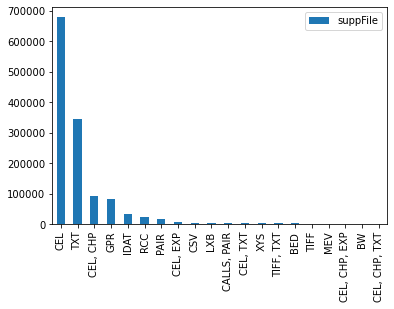

In [177]:
pd.DataFrame(merged.suppFile.value_counts()).head(n=20).plot(kind='bar')

In [187]:
gruppo = merged.groupby(by='suppFile')
[(i,j) for i,j in list(gruppo) if i == 'CEL']

[('CEL',
                  Id   Accession       GPL     GSE                  taxon  \
  223      306997293  GSM6997293  GPL23038  223818           Mus musculus   
  224      304074493  GSM4074493  GPL23038  137281           Mus musculus   
  226      305689479  GSM5689479  GPL23038  188764           Mus musculus   
  227      305024406  GSM5024406  GPL23038  165006           Mus musculus   
  228      305352434  GSM5352434  GPL23038  175993           Mus musculus   
  ...            ...         ...       ...     ...                    ...   
  1766017  301019389  GSM1019389  GPL16175   41567  Plasmodium falciparum   
  1766018  301019388  GSM1019388  GPL16175   41567  Plasmodium falciparum   
  1766019  301019387  GSM1019387  GPL16175   41567  Plasmodium falciparum   
  1766159  300243240   GSM243240   GPL6137    9613           Homo sapiens   
  1766160  300243196   GSM243196   GPL6137    9613           Homo sapiens   
  
                 PDAT suppFile  \
  223      2023/09/29      CEL

In [196]:
print(sum(merged.FTPLink.isna()))
sum(merged.suppFile.isna())

424067


424067

<AxesSubplot:>

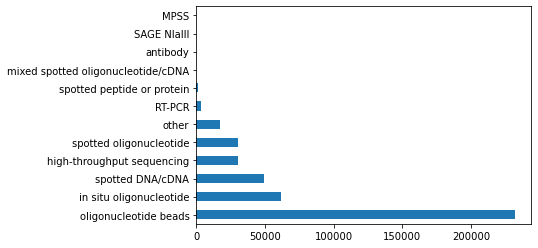

In [204]:
merged[merged.FTPLink.isna()].technology.value_counts().plot(kind="barh")

In [201]:
sum(merged.technology == "high-throughput sequencing")

51199

In [193]:
424067/merged.shape[0]

0.2400926475317393

In [4]:
merged = pd.read_csv("../../data/GEOData/GSMs_GPLs_data.tsv", sep='\t', index_col="Unnamed: 0")
merged

/export/apps/bioconda/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (12,14) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
/export/apps/bioconda/lib/python3.8/site-packages/numpy/lib/arraysetops.py:583: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,Id,Accession,GPL,GSE,taxon,PDAT,suppFile,FTPLink,technology,distribution,organism,taxid,manufacturer,supplementary_file,data_row_count
0,301115610.0,GSM1115610,GPL16969,45801,Drosophila serrata,2013/11/05,PAIR,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM1115...,in situ oligonucleotide,custom-commercial,Drosophila serrata,7274,NimbleGen,ftp://ftp.ncbi.nlm.nih.gov/geo/platforms/GPL16...,11631.0
1,301115599.0,GSM1115599,GPL16969,45801,Drosophila serrata,2013/11/05,PAIR,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM1115...,in situ oligonucleotide,custom-commercial,Drosophila serrata,7274,NimbleGen,ftp://ftp.ncbi.nlm.nih.gov/geo/platforms/GPL16...,11631.0
2,301115636.0,GSM1115636,GPL16969,45801,Drosophila serrata,2013/11/05,PAIR,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM1115...,in situ oligonucleotide,custom-commercial,Drosophila serrata,7274,NimbleGen,ftp://ftp.ncbi.nlm.nih.gov/geo/platforms/GPL16...,11631.0
3,301115743.0,GSM1115743,GPL16969,45801,Drosophila serrata,2013/11/05,PAIR,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM1115...,in situ oligonucleotide,custom-commercial,Drosophila serrata,7274,NimbleGen,ftp://ftp.ncbi.nlm.nih.gov/geo/platforms/GPL16...,11631.0
4,302411571.0,GSM2411571,GPL16969,90733,Drosophila serrata,2017/01/04,PAIR,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM2411...,in situ oligonucleotide,custom-commercial,Drosophila serrata,7274,NimbleGen,ftp://ftp.ncbi.nlm.nih.gov/geo/platforms/GPL16...,11631.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1766259,302091621.0,GSM2091621,GPL21606,79328;79330,Homo sapiens,2017/10/30,GPR,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM2091...,spotted oligonucleotide,non-commercial,Homo sapiens,9606,Stanford: functional genomics facility,ftp://ftp.ncbi.nlm.nih.gov/geo/platforms/GPL21...,38109.0
1766260,300493193.0,GSM493193,GPL6125,19762,Histoplasma capsulatum,2010/12/05,GPR,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM493n...,spotted oligonucleotide,non-commercial,Histoplasma capsulatum,5037,"Sil Lab, UCSF",NaN,14962.0
1766261,300339701.0,GSM339701,GPL7561,13473,Caenorhabditis elegans,2008/11/06,NaN,NaN,spotted DNA/cDNA,non-commercial,Caenorhabditis elegans,6239,"Stanford Functional Genomics Facility, Stanfor...",ftp://ftp.ncbi.nlm.nih.gov/geo/platforms/GPL7n...,21504.0
1766262,301552698.0,GSM1552698,GPL19148,60603;60605,Pan troglodytes,2015/05/06,NaN,NaN,high-throughput sequencing,virtual,Pan troglodytes,9598,NaN,NaN,0.0


In [5]:
merged_2 = merged[merged.technology != "high-throughput sequencing"]

<AxesSubplot:>

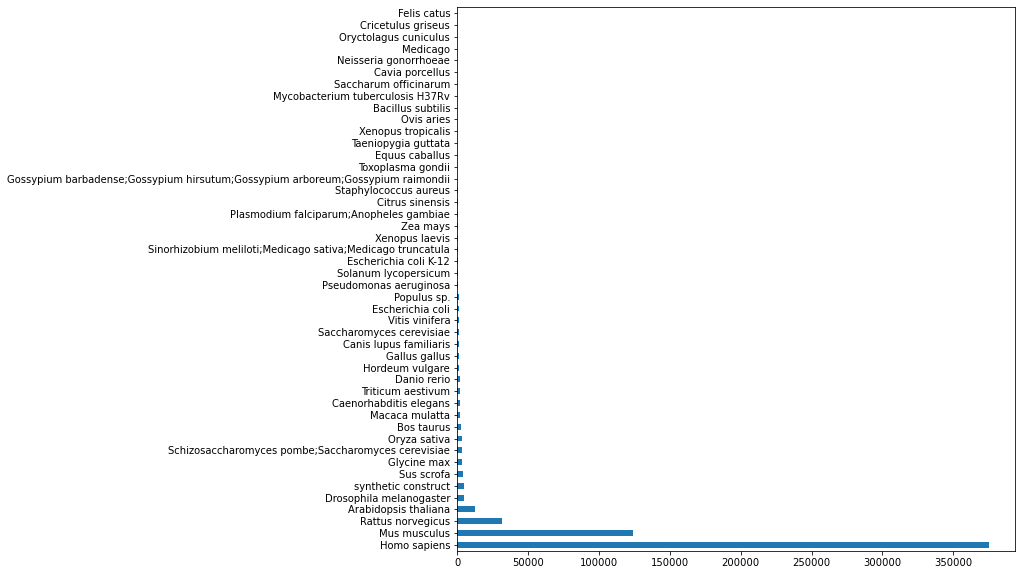

In [213]:
merged_2[(merged_2.suppFile == "CEL") & (merged_2.distribution == "commercial") ].organism.value_counts().plot(kind="barh", figsize=(10,10))

In [253]:
import re

In [228]:
len([i for i in merged_2[merged_2.manufacturer == "Affymetrix"].suppFile.to_list() if type(i) != str ])

27421

In [235]:
a = merged_2[(merged_2.suppFile.isna()) & (merged_2.manufacturer == "Affymetrix")]
a.sort_values(by="PDAT", ascending=False)

,Id,Accession,GPL,GSE,taxon,PDAT,suppFile,FTPLink,technology,distribution,organism,taxid,manufacturer,supplementary_file,data_row_count
773219,306943910,GSM6943910,GPL96,223251,Homo sapiens,2023/07/27,NaN,NaN,in situ oligonucleotide,commercial,Homo sapiens,9606,Affymetrix,NaN,22283.0
752945,306943904,GSM6943904,GPL96,223251,Homo sapiens,2023/07/27,NaN,NaN,in situ oligonucleotide,commercial,Homo sapiens,9606,Affymetrix,NaN,22283.0
770604,306943891,GSM6943891,GPL96,223251,Homo sapiens,2023/07/27,NaN,NaN,in situ oligonucleotide,commercial,Homo sapiens,9606,Affymetrix,NaN,22283.0
770125,306943907,GSM6943907,GPL96,223251,Homo sapiens,2023/07/27,NaN,NaN,in situ oligonucleotide,commercial,Homo sapiens,9606,Affymetrix,NaN,22283.0
769681,306943889,GSM6943889,GPL96,223251,Homo sapiens,2023/07/27,NaN,NaN,in situ oligonucleotide,commercial,Homo sapiens,9606,Affymetrix,NaN,22283.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1106937,300000647,GSM647,GPL76,13;272,Mus musculus,2001/12/17,NaN,NaN,in situ oligonucleotide,commercial,Mus musculus,10090,Affymetrix,NaN,6595.0
1106965,300000637,GSM637,GPL76,13;272,Mus musculus,2001/12/17,NaN,NaN,in situ oligonucleotide,commercial,Mus musculus,10090,Affymetrix,NaN,6595.0
1106977,300000644,GSM644,GPL76,13;272,Mus musculus,2001/12/17,NaN,NaN,in situ oligonucleotide,commercial,Mus musculus,10090,Affymetrix,NaN,6595.0
1106661,300000662,GSM662,GPL76,13;272,Mus musculus,2001/12/17,NaN,NaN,in situ oligonucleotide,commercial,Mus musculus,10090,Affymetrix,NaN,6595.0


<AxesSubplot:>

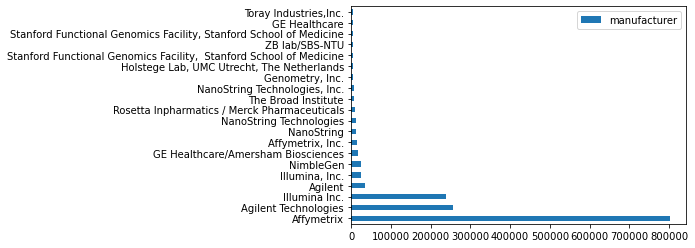

In [239]:
pd.DataFrame(merged_2.manufacturer.value_counts()).sort_values('manufacturer', ascending=False).head(n=20).plot(kind='barh')

<AxesSubplot:>

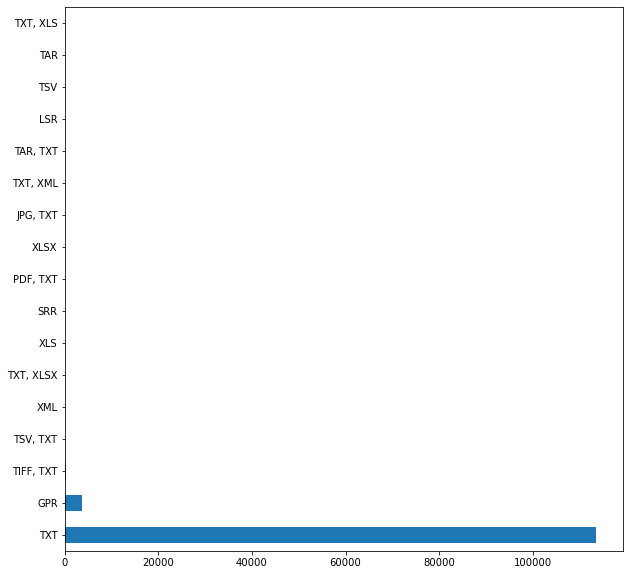

In [245]:
merged_2[(merged_2.manufacturer == "Agilent Technologies" ) & (merged_2.distribution == "commercial") ].suppFile.value_counts().plot(kind="barh", figsize=(10,10))

In [247]:
merged_2[(merged_2.manufacturer == "Illumina Inc.") & (~merged_2.FTPLink.isna())]

,Id,Accession,GPL,GSE,taxon,PDAT,suppFile,FTPLink,technology,distribution,organism,taxid,manufacturer,supplementary_file,data_row_count
269893,300523194,GSM523194,GPL6105,20912,Mus musculus,2010/04/01,IDAT,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM523n...,oligonucleotide beads,commercial,Mus musculus,10090,Illumina Inc.,ftp://ftp.ncbi.nlm.nih.gov/geo/platforms/GPL6n...,46632.0
269937,300523198,GSM523198,GPL6105,20912,Mus musculus,2010/04/01,IDAT,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM523n...,oligonucleotide beads,commercial,Mus musculus,10090,Illumina Inc.,ftp://ftp.ncbi.nlm.nih.gov/geo/platforms/GPL6n...,46632.0
269938,300523190,GSM523190,GPL6105,20912,Mus musculus,2010/04/01,IDAT,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM523n...,oligonucleotide beads,commercial,Mus musculus,10090,Illumina Inc.,ftp://ftp.ncbi.nlm.nih.gov/geo/platforms/GPL6n...,46632.0
269962,301020250,GSM1020250,GPL6105,41620,Mus musculus,2012/10/17,CSV,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM1020...,oligonucleotide beads,commercial,Mus musculus,10090,Illumina Inc.,ftp://ftp.ncbi.nlm.nih.gov/geo/platforms/GPL6n...,46632.0
270026,300359284,GSM359284,GPL6105,14367,Mus musculus,2009/01/10,TXT,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM359n...,oligonucleotide beads,commercial,Mus musculus,10090,Illumina Inc.,ftp://ftp.ncbi.nlm.nih.gov/geo/platforms/GPL6n...,46632.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1761906,300237797,GSM237797,GPL6014,9340,Homo sapiens,2007/10/16,TXT,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM237n...,oligonucleotide beads,commercial,Homo sapiens,9606,Illumina Inc.,NaN,22178.0
1761907,300237800,GSM237800,GPL6014,9340,Homo sapiens,2007/10/16,TXT,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM237n...,oligonucleotide beads,commercial,Homo sapiens,9606,Illumina Inc.,NaN,22178.0
1761908,300237799,GSM237799,GPL6014,9340,Homo sapiens,2007/10/16,TXT,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM237n...,oligonucleotide beads,commercial,Homo sapiens,9606,Illumina Inc.,NaN,22178.0
1761909,300237804,GSM237804,GPL6014,9340,Homo sapiens,2007/10/16,TXT,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM237n...,oligonucleotide beads,commercial,Homo sapiens,9606,Illumina Inc.,NaN,22178.0


In [214]:
merged_2.columns

Index(['Id', 'Accession', 'GPL', 'GSE', 'taxon', 'PDAT', 'suppFile', 'FTPLink',
       'technology', 'distribution', 'organism', 'taxid', 'manufacturer',
       'supplementary_file', 'data_row_count'],
      dtype='object')

In [6]:
merged_3 = merged_2[~merged_2.suppFile.isna()]

In [7]:
merged_3.to_csv("../../data/GEOData/GSMs_GPLs_data_filt.tsv")

In [293]:
pd.DataFrame(merged_3.manufacturer.value_counts()).sort_values('manufacturer', ascending=False).head(n=30)

,manufacturer
Affymetrix,774433
Agilent Technologies,241560
Illumina Inc.,35031
Agilent,28834
NimbleGen,23213
"Affymetrix, Inc.",14758
GE Healthcare/Amersham Biosciences,12977
"Illumina, Inc.",10252
NanoString Technologies,10195
NanoString,5390


In [256]:
set([i for i in merged_3.manufacturer.to_list() if type(i) == str and re.findall("nimble", i, flags=re.IGNORECASE)])

{'NimbleExpress',
 'NimbleGen',
 'NimbleGen (Roche)',
 'NimbleGen (www.nimblegen.com)',
 'NimbleGen Inc.',
 'NimbleGen System Inc',
 'NimbleGen Systems',
 'NimbleGen Systems Inc.',
 'NimbleGen Systems, Inc',
 'NimbleGen Systems, Inc.',
 'NimbleGen systems inc.',
 'NimbleGene',
 'Nimblegen',
 'Nimblegen Systems',
 'Nimblegen Systems Inc',
 'Nimblegen Systems Inc.',
 'Nimblegen Systems, INC',
 'Nimblegen Systems, INC.',
 'Nimblegen Systems, Inc.',
 'Nimblegen Systems, Inc. (Madison, WI)',
 'Roche (NimbleGen, Inc.)',
 'Roche - Nimblegen',
 'Roche NimbleGen',
 'Roche NimbleGen Inc.',
 'Roche NimbleGen Systems Inc.',
 'Roche NimbleGen, Inc.',
 'Roche Nimblegen',
 'Roche Nimblegen, Inc.',
 'Roche-NimbleGen',
 'nimblegen'}

<AxesSubplot:>

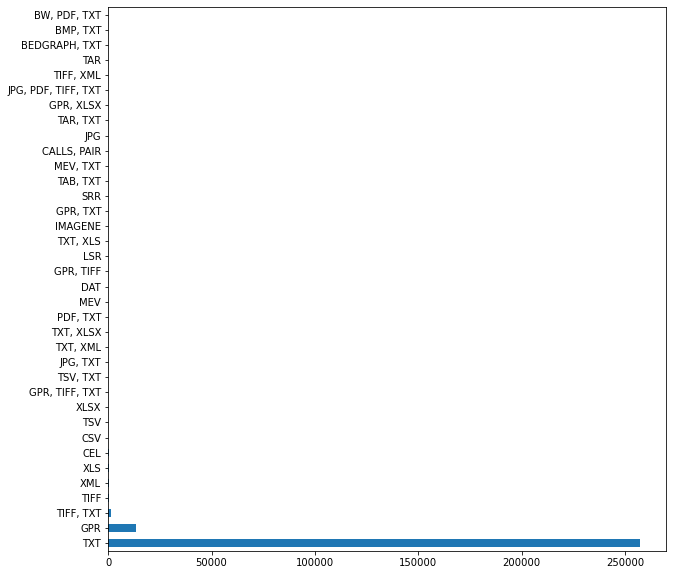

In [272]:
merged_3[(~merged_3.manufacturer.isna()) & (merged_3.manufacturer.str.contains("agil", case=False))].suppFile.value_counts().plot(kind='barh', figsize=(10,10))

<AxesSubplot:>

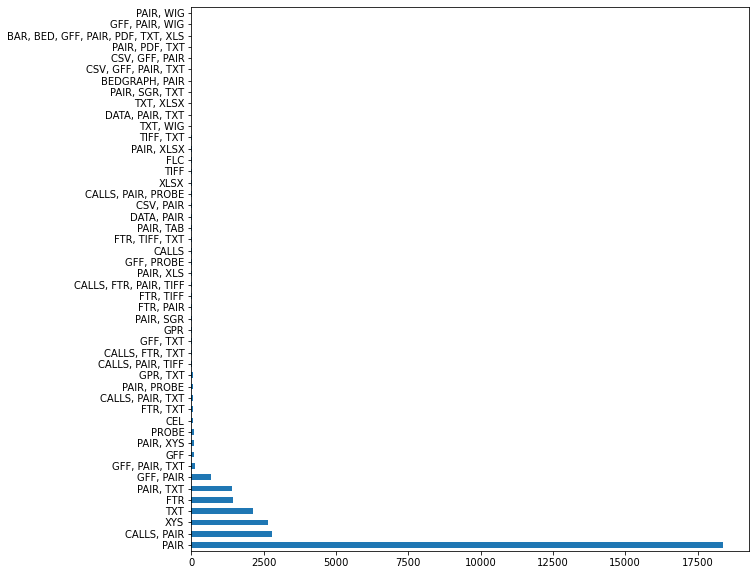

In [273]:
merged_3[(~merged_3.manufacturer.isna()) & (merged_3.manufacturer.str.contains("nimble", case=False))].suppFile.value_counts().plot(kind='barh', figsize=(10,10))

In [251]:
merged_3[merged_3.manufacturer == "NimbleGen"]

,Id,Accession,GPL,GSE,taxon,PDAT,suppFile,FTPLink,technology,distribution,organism,taxid,manufacturer,supplementary_file,data_row_count
0,301115610,GSM1115610,GPL16969,45801,Drosophila serrata,2013/11/05,PAIR,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM1115...,in situ oligonucleotide,custom-commercial,Drosophila serrata,7274,NimbleGen,ftp://ftp.ncbi.nlm.nih.gov/geo/platforms/GPL16...,11631.0
1,301115599,GSM1115599,GPL16969,45801,Drosophila serrata,2013/11/05,PAIR,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM1115...,in situ oligonucleotide,custom-commercial,Drosophila serrata,7274,NimbleGen,ftp://ftp.ncbi.nlm.nih.gov/geo/platforms/GPL16...,11631.0
2,301115636,GSM1115636,GPL16969,45801,Drosophila serrata,2013/11/05,PAIR,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM1115...,in situ oligonucleotide,custom-commercial,Drosophila serrata,7274,NimbleGen,ftp://ftp.ncbi.nlm.nih.gov/geo/platforms/GPL16...,11631.0
3,301115743,GSM1115743,GPL16969,45801,Drosophila serrata,2013/11/05,PAIR,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM1115...,in situ oligonucleotide,custom-commercial,Drosophila serrata,7274,NimbleGen,ftp://ftp.ncbi.nlm.nih.gov/geo/platforms/GPL16...,11631.0
4,302411571,GSM2411571,GPL16969,90733,Drosophila serrata,2017/01/04,PAIR,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM2411...,in situ oligonucleotide,custom-commercial,Drosophila serrata,7274,NimbleGen,ftp://ftp.ncbi.nlm.nih.gov/geo/platforms/GPL16...,11631.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1766208,300726829,GSM726829,GPL13588,29394;29395,Mus musculus,2011/05/19,"GFF, PAIR, TXT",ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM726n...,in situ oligonucleotide,commercial,Mus musculus,10090,NimbleGen,ftp://ftp.ncbi.nlm.nih.gov/geo/platforms/GPL13...,385496.0
1766209,300726867,GSM726867,GPL13588,29394;29395,Mus musculus,2011/05/19,"GFF, PAIR, TXT",ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM726n...,in situ oligonucleotide,commercial,Mus musculus,10090,NimbleGen,ftp://ftp.ncbi.nlm.nih.gov/geo/platforms/GPL13...,385496.0
1766238,300726823,GSM726823,GPL13582,29394;29395,Mus musculus,2011/05/19,"GFF, PAIR, TXT",ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM726n...,in situ oligonucleotide,commercial,Mus musculus,10090,NimbleGen,ftp://ftp.ncbi.nlm.nih.gov/geo/platforms/GPL13...,385496.0
1766239,300726861,GSM726861,GPL13582,29394;29395,Mus musculus,2011/05/19,"GFF, PAIR, TXT",ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM726n...,in situ oligonucleotide,commercial,Mus musculus,10090,NimbleGen,ftp://ftp.ncbi.nlm.nih.gov/geo/platforms/GPL13...,385496.0


In [291]:
merged_3[(~merged_3.manufacturer.isna()) & (merged_3.manufacturer.str.contains("unam", case=False))]

,Id,Accession,GPL,GSE,taxon,PDAT,suppFile,FTPLink,technology,distribution,organism,taxid,manufacturer,supplementary_file,data_row_count
1711800,304628302,GSM4628302,GPL18099,152877,Rattus norvegicus,2020/06/20,TXT,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM4628...,spotted oligonucleotide,non-commercial,Mus musculus,10090,"Unidad de Microarreglos, IFC UNAM, México",NaN,23232.0
1711801,306073758,GSM6073758,GPL18099,201828,Mus musculus,2022/05/01,TXT,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM6073...,spotted oligonucleotide,non-commercial,Mus musculus,10090,"Unidad de Microarreglos, IFC UNAM, México",NaN,23232.0
1711802,301295991,GSM1295991,GPL18099,53547,Mus musculus,2013/12/21,XLS,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM1295...,spotted oligonucleotide,non-commercial,Mus musculus,10090,"Unidad de Microarreglos, IFC UNAM, México",NaN,23232.0
1711803,301295990,GSM1295990,GPL18099,53547,Mus musculus,2013/12/21,XLS,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM1295...,spotted oligonucleotide,non-commercial,Mus musculus,10090,"Unidad de Microarreglos, IFC UNAM, México",NaN,23232.0
1711804,304734056,GSM4734056,GPL18099,156579,Rattus norvegicus,2020/08/21,TXT,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM4734...,spotted oligonucleotide,non-commercial,Mus musculus,10090,"Unidad de Microarreglos, IFC UNAM, México",NaN,23232.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1765139,300468773,GSM468773,GPL9541,18921,Homo sapiens,2009/11/13,TXT,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM468n...,spotted oligonucleotide,non-commercial,Homo sapiens,9606,DNA Microarray unit of Cellular Physiology Ins...,NaN,19968.0
1765270,306659801,GSM6659801,GPL32762,216174,Mus musculus,2022/10/22,XLS,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM6659...,spotted oligonucleotide,non-commercial,Mus musculus,10090,"Unidad de Microarreglos, IFC UNAM, México",NaN,21610.0
1765271,306659800,GSM6659800,GPL32762,216173,Mus musculus,2022/10/22,XLS,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM6659...,spotted oligonucleotide,non-commercial,Mus musculus,10090,"Unidad de Microarreglos, IFC UNAM, México",NaN,21610.0
1765272,306659799,GSM6659799,GPL32762,216172,Mus musculus,2022/10/22,XLS,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM6659...,spotted oligonucleotide,non-commercial,Mus musculus,10090,"Unidad de Microarreglos, IFC UNAM, México",NaN,21610.0


<AxesSubplot:>

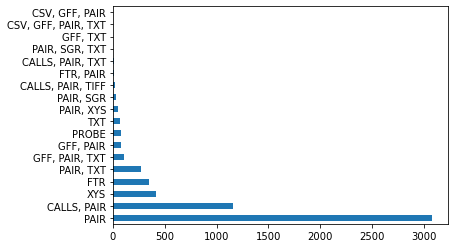

In [294]:
merged_3[(~merged_3.manufacturer.isna()) & (merged_3.manufacturer.str.contains("nimble", case=False)) & (merged_3.distribution == "commercial")].suppFile.value_counts().plot(kind="barh")

# 8 de noviembre de 2023

## Plots de GSMs-GPLs

*Trabajar con merged_2*
- Agregar columna de domain -> plotear 
- Consulta para todas las bacterias (Modificar código)
    - Correr análisis de metadata
- Plot raw availability
    - Considerar affy + CEL + commercial / agilent + txt + commercial / nimblegen + pair + commercial (Procesable)
    - supplFile == NA, tipo de suppl no legible [TIFF, PNG, JPEG ...], no descargable ?? (no procesable)
    - resto??, cualquier que requiera de algun paso adicional (semi-procesable)
- Plot suppl type 
- plot suppl count per gsm 




### Init

In [111]:
import pandas as pd
from Bio import Entrez
Entrez.email = "diegocar@lcg.unam.mx"
Entrez.apikey = "34677fdcfd2f0659a7f9ee05ab6e44704f09"

In [ ]:
# Elimina los archivos suplementarios vacíos
#data = merged_3 
#data = pd.read_csv("../../data/GEOData/GSMs_GPLs_data_filt.csv", index_col="Unnamed: 0")

In [138]:
# Elimina RNA Seq
#merged_2.to_csv("../../data/GEOData/GSM_GPL_noRNAseq.csv")
#data = pd.read_csv("../../data/GEOData/GSM_GPL_noRNAseq.csv", index_col="Unnamed: 0")
data = pd.read_csv("../../data/GEOData/GSMs_md_suppl_class.tsv", sep='\t')

/export/apps/bioconda/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (11,13) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [139]:
# Taxon lineage
taxon = pd.read_csv("../../data/GEOData/all_GEO_lineages.csv")
#gsms = pd.merge(data, taxon)
#gsms = pd.read_csv("../../data/GEOData/GSMs_lineage_Ex.tsv", sep='\t')

In [141]:
taxon.shape

(1814, 37)

In [142]:
print(pd.merge(data, taxon).shape)
print(pd.merge(data, taxon, on='taxon').shape)

(1701418, 53)
(1701418, 53)


In [153]:
list(taxon[taxon.taxon == 'Escherichia coli str. K-12 substr. MG1655'].values)

[array(['Escherichia coli str. K-12 substr. MG1655', '511145',
        'cellular organisms', 'Bacteria', nan, 'Pseudomonadota', nan, nan,
        'Gammaproteobacteria', 'Vibrionales', 'Vibrionaceae', nan,
        'Photobacterium', nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan], dtype=object)]

In [144]:
pd.merge(data, taxon, on='taxon')[pd.merge(data, taxon, on='taxon').Accession == 'GSM2109791'].taxon

1450218    Escherichia coli str. K-12 substr. MG1655
Name: taxon, dtype: object

In [115]:
not_recov_orgs = {i for  i in set(data.taxon) - set(gsms.taxon) if not ';' in i and not ' x ' in i}
len(not_recov_orgs)

55

### Agregar columna de domain -> plotear 

<AxesSubplot:>

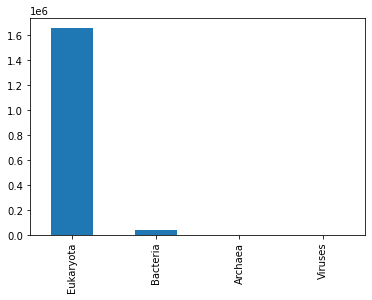

In [5]:

gsms.superkingdom.value_counts().plot(kind="bar")

### Consulta para todas las bacterias (Modificar código)
    Correr análisis de metadata

In [39]:
bacteria = gsms[gsms.superkingdom == "Bacteria"]

In [41]:
bacteria.Accession

1449932    GSM2109848
1449933     GSM909101
1449934     GSM867013
1449935    GSM1412770
1449936    GSM1356340
              ...    
1701412      GSM89132
1701413    GSM1714042
1701415    GSM1305854
1701416    GSM1305855
1701417    GSM1199772
Name: Accession, Length: 40725, dtype: object

In [79]:
import GEOparse as g
from time import sleep
import os

def get_gsm_object(gsm_id, path='./'):

  try:
    gsm = g.get_GEO(geo=gsm_id, destdir=path, silent=True)
    #logging.info("Soft File %s %s", gse_ID, file_size)
    
    os.remove(f'{path}/{gsm_id}.txt')
    return(gsm)
  except:
    #logging.warning("No se pudo parsear el GSE %s", gse_ID)
    return(None)
  
def get_gsm_metadata(gsm_id):
   gsm = get_gsm_object(gsm_id)
   return({k: ';'.join(v) for k,v in  gsm.metadata.items()})
    

In [82]:
get_gsm_metadata("GSM909101")

{'title': 'control sample at 60 min, biological rep2',
 'geo_accession': 'GSM909101',
 'status': 'Public on Nov 26 2012',
 'submission_date': 'Apr 04 2012',
 'last_update_date': 'Nov 26 2012',
 'type': 'RNA',
 'channel_count': '1',
 'source_name_ch1': 'Escherichia coli MG1655 after 60 min incubation',
 'organism_ch1': 'Escherichia coli str. K-12 substr. MG1655',
 'taxid_ch1': '511145',
 'characteristics_ch1': 'treatment: untreated culture',
 'treatment_protocol_ch1': 'When the cultures reached an OD600 0.6 they were split into two flasks, each containing 20 ml of the culture. One was treated with a subinhibitory concentration of purified colicin M, while the untreated served as a control. 2-ml culture aliquotes were harvested from each flask after 30 min and 60 min incubation at 37°C  and were mixed with 4 ml RNAProtect Bacteria Reagent (Qiagen).',
 'growth_protocol_ch1': 'Overnight cultures of E. coli MG1655  grown at 37°C with shaking at 200 rpm were diluted 1:625 into 50 ml of LB br

In [85]:

with open("../../data/GEOData/bacteria_gsms.txt", "w") as file:
    for gsm in bacteria.Accession.unique():
        file.write(f"{gsm}\n")

In [86]:

with open("../../data/GEOData/bacteria_gsms_2.txt", "w") as file:
    for gsm in bacteria.Accession.unique()[:10]:
        file.write(f"{gsm}\n")

### Plot raw availability
    - Considerar affy + CEL + commercial / agilent + txt + commercial / nimblegen + pair + commercial / illumina + idat + commercial (Procesable)
    - supplFile == NA, tipo de suppl no legible [TIFF, PNG, JPEG ...], no descargable ?? (no procesable)
    - resto??, cualquier que requiera de algun paso adicional (semi-procesable)

<AxesSubplot:>

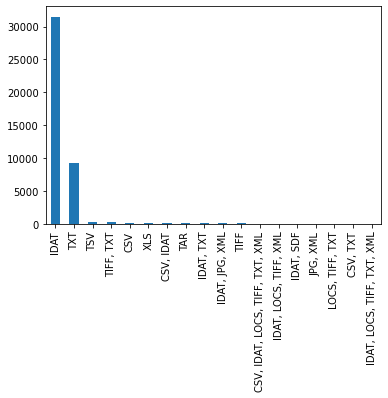

In [6]:
# Illumina supp Files
data[(~data.manufacturer.isna()) & (data.manufacturer.str.contains("illum", case=False)) & (data.distribution == "commercial")].suppFile.value_counts().plot(kind='bar')

<AxesSubplot:>

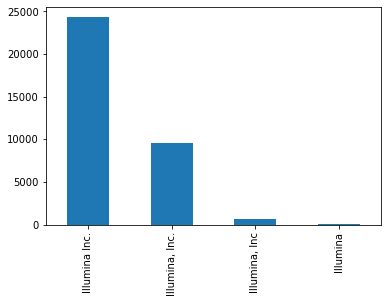

In [7]:
# IDAT files manufacturer
data[(~data.manufacturer.isna()) & (data.suppFile.str.contains("idat", case=False))].manufacturer.value_counts().plot(kind='bar')

In [8]:
import re
def class_sup(row):
    man  = row.manufacturer
    dist = row.distribution
    file = row.suppFile
    procesable = 0

    if type(file) == float or type(man) == float or  type(dist) == float: return("Unprocesable")
    if dist == "commercial": 
        if re.search("affymetrix", man, flags=re.IGNORECASE) and re.search("cel", file, flags=re.IGNORECASE): procesable = 1
        if re.search("agilent", man, flags=re.IGNORECASE) and re.search("txt", file, flags=re.IGNORECASE): procesable = 1
        if re.search("nimble", man, flags=re.IGNORECASE) and re.search("pair", file, flags=re.IGNORECASE): procesable = 1
        if re.search("illumina", man, flags=re.IGNORECASE) and re.search("idat", file, flags=re.IGNORECASE): procesable = 1
    if procesable : return("Procesable")
    return("Semiprocesable")

In [9]:
data["Flag"] = [class_sup(row) for i,row in data.iterrows()]

<AxesSubplot:title={'center':'Supplementary file availability'}>

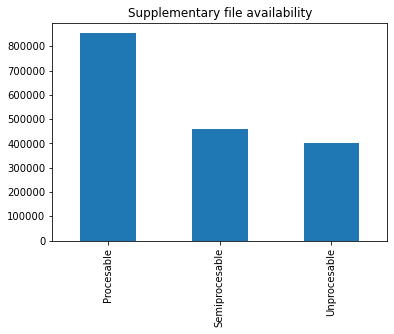

In [10]:
data.Flag.value_counts().plot(kind="bar", title="Supplementary file availability")

In [180]:
data.Flag.value_counts()/data.shape[0]*100

Procesable        49.748377
Semiprocesable    26.774204
Unprocesable      23.477419
Name: Flag, dtype: float64

### Plot suppl type 

### Plot suppl count per gsm 

<AxesSubplot:title={'center':'Suppl count distribution'}>

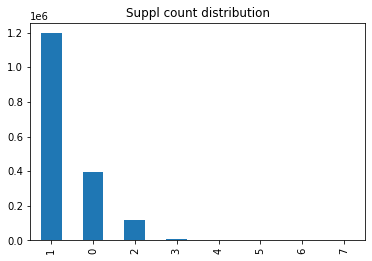

In [11]:
data["SupplCount"] = [len(row.suppFile.split(',')) if type(row.suppFile) == str else 0 for i,row in data.iterrows() ]
data.SupplCount.value_counts().plot(kind="bar", title="Suppl count distribution")

<AxesSubplot:title={'center':'Suppl count distribution'}, ylabel='Density'>

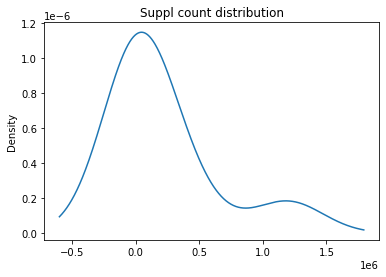

In [12]:
data.SupplCount.value_counts().plot(kind="kde", title="Suppl count distribution")

### Manufacturer biass

In [5]:
import matplotlib.pyplot as plt
def count(df, col1, col2, c):
    return(df[(~df[col1].isna()) & (df[col1].str.contains(c, case=False))][col2].value_counts())

def plot(data, col1, col2, patterns,**kargs):
    f = plt.figure()
    a = {man: count(data,col1, col2, man) for man in patterns}
    b = pd.DataFrame.from_dict(a).T
    b.plot( **kargs)
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    plt.show()

def plot_2(data, col1, col2, patterns,**kargs):
    f = plt.figure()
    a = {man: count(data,col1, col2, man).sort_values(ascending=False).head() for man in patterns}
    b = pd.DataFrame.from_dict(a).T
    b.plot(**kargs)
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    plt.show()


<Figure size 432x288 with 0 Axes>

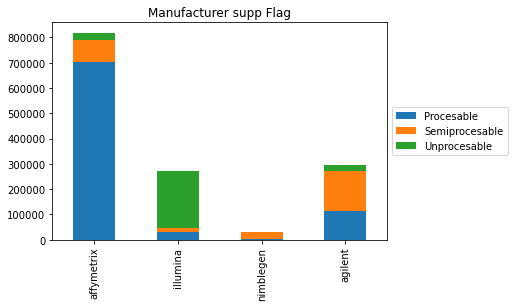

In [129]:
manufacturers = ["affymetrix", "illumina", "nimblegen", "agilent"]
plot(data, "manufacturer", "Flag", manufacturers, title="Manufacturer supp Flag", kind="bar", stacked=True)

<Figure size 432x288 with 0 Axes>

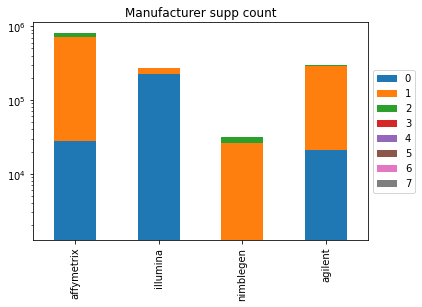

In [130]:
plot(data, "manufacturer", "SupplCount", manufacturers, title="Manufacturer supp count", logy=True, kind="bar", stacked=True)

<Figure size 432x288 with 0 Axes>

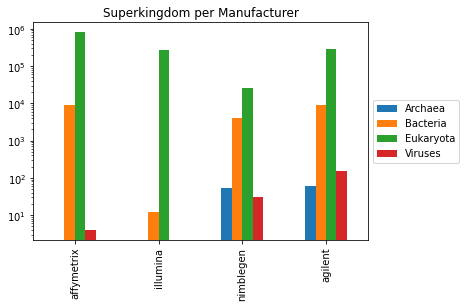

In [131]:
plot(gsms, "manufacturer", "superkingdom", manufacturers, kind="bar", logy=True, title="Superkingdom per Manufacturer")

<Figure size 432x288 with 0 Axes>

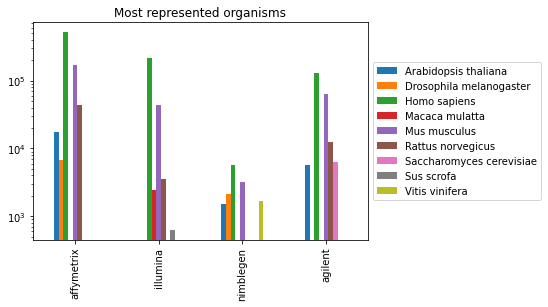

In [132]:
plot_2(gsms, "manufacturer", "taxon", manufacturers, kind="bar", logy=True, title="Most represented organisms")

<Figure size 432x288 with 0 Axes>

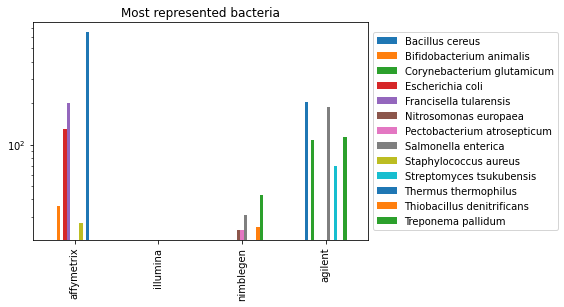

In [133]:
plot_2(gsms[gsms.superkingdom == "Bacteria"], "manufacturer", "species", manufacturers, title="Most represented bacteria", kind="bar", logy=True)

<AxesSubplot:>

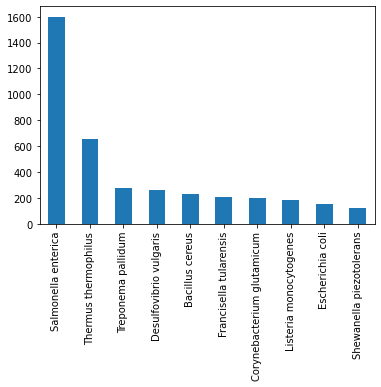

In [136]:
gsms[ (~gsms.species.isna()) & (gsms.superkingdom == "Bacteria")].species.value_counts().head(n=10).plot(kind="bar")

In [12]:
bacteria = gsms[gsms.superkingdom == "Bacteria"]
#bacteria[(~bacteria.species.isna()) & (~bacteria.suppFile.isna())]
bacteria[~bacteria.species.isna()].shape

(5396, 50)

In [140]:
gsms[(gsms.taxon.str.contains("escherichia coli", case=False)) & (gsms.species.isna()) ].taxon.unique()

array(['Escherichia coli str. K-12 substr. MG1655',
       'Escherichia coli O157:H7 str. EDL933', 'Escherichia coli O157:H7',
       'Escherichia coli', 'Escherichia coli K-12',
       'Escherichia coli str. K-12 substr. MC4100',
       'Escherichia coli str. K-12 substr. W3110',
       'Escherichia coli str. K-12 substr. DH10B',
       'Escherichia coli UTI89', 'Escherichia coli O157',
       'Escherichia coli 8624', 'Escherichia coli O55:H7',
       'Escherichia coli APEC O2', 'Escherichia coli SCI-07',
       'Escherichia coli str. K-12 substr. MDS42',
       'Escherichia coli O157:H7 str. Sakai',
       'Escherichia coli str. K-12 substr. MG1655star',
       'Escherichia coli O103:H25',
       'Escherichia coli O139:H28 str. E24377A',
       'Escherichia coli O127:H6 str. E2348/69', 'Escherichia coli E22',
       'Escherichia coli BL21'], dtype=object)

In [142]:
gsms[gsms["species group"].isna()]

,Id,Accession,GPL,GSE,taxon,PDAT,suppFile,FTPLink,technology,distribution,...,species group,species subgroup,serogroup,parvorder,subspecies,section,subcohort,strain,biotype,subsection
387,306997293.0,GSM6997293,GPL23038,223818,Mus musculus,2023/09/29,CEL,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM6997...,in situ oligonucleotide,commercial,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
388,304074493.0,GSM4074493,GPL23038,137281,Mus musculus,2020/05/01,CEL,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM4074...,in situ oligonucleotide,commercial,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
389,305663316.0,GSM5663316,GPL23038,186900,Mus musculus,2021/11/03,"CEL, CHP",ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM5663...,in situ oligonucleotide,commercial,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
390,305689479.0,GSM5689479,GPL23038,188764,Mus musculus,2022/09/27,CEL,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM5689...,in situ oligonucleotide,commercial,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
391,305024406.0,GSM5024406,GPL23038,165006,Mus musculus,2021/09/01,CEL,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM5024...,in situ oligonucleotide,commercial,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1701413,301714042.0,GSM1714042,GPL20577,69963,Escherichia coli BL21,2015/06/18,GPR,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM1714...,in situ oligonucleotide,custom-commercial,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1701414,300050839.0,GSM50839,GPL2036,2648,Lilium longiflorum,2006/03/23,NaN,NaN,spotted DNA/cDNA,non-commercial,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1701415,301305854.0,GSM1305854,GPL18161,54012,Neochlamydia sp. S13,2014/12/31,TXT,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM1305...,in situ oligonucleotide,custom-commercial,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1701416,301305855.0,GSM1305855,GPL18161,54012,Neochlamydia sp. S13,2014/12/31,TXT,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM1305...,in situ oligonucleotide,custom-commercial,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [127]:
from Bio import Entrez
Entrez.email="diegocar@lcg.unam.mx"

In [128]:
def get_id (org):
    with Entrez.esearch(db="taxonomy", term=org) as handle:
        record = Entrez.read(handle)
    try: return(record['IdList'][0])
    except: return(None)

In [130]:
not_recov_orgs

{'Actinobacillus pleuropneumoniae serovar 1 str. 4074',
 'Bacteroides xylanisolvens XB1A',
 'Brucella melitensis bv. 1 str. 16M',
 'Buchnera aphidicola (Schizaphis graminum)',
 'Deinococcus radiodurans R1 = ATCC 13939 = DSM 20539',
 'Desulforamulus reducens MI-1',
 'Enterococcus faecalis OG1RF',
 'Escherichia coli APEC O1',
 'Escherichia coli BL21(DE3)',
 'Escherichia coli DH1',
 'Escherichia coli DH5[alpha]',
 'Halobacterium salinarum NRC-1',
 'Helicobacter pylori SS1',
 'Human alphaherpesvirus 1',
 'Influenza A virus (A/Texas/36/1991(H1N1))',
 'Lactiplantibacillus plantarum WCFS1',
 'Legionella pneumophila subsp. pneumophila str. Philadelphia 1',
 'Leptospira interrogans serovar Copenhageni str. Fiocruz L1-130',
 'Magnetospirillum magneticum AMB-1',
 'Methylibium petroleiphilum PM1',
 'Methylorubrum extorquens AM1',
 'Moineauvirus DT1',
 'Nitrosopumilus maritimus SCM1',
 'Oenococcus oeni PSU-1',
 'Paracoccidioides lutzii Pb01',
 'Paramecium bursaria Chlorella virus 1',
 'Photorhabdus

In [129]:
orgs = {org : get_id(f'"{org}"') for  org in not_recov_orgs}

RuntimeError: Search Backend failed: Couldn't resolve #PMQuerySrv_2_0?dbaf=taxonomy, the address table is empty.

In [125]:
recovered = {k:v for k,v in orgs.items() if v}


In [126]:
recovered

{}

In [37]:
[i for i,j  in recovered.items() if j == "10239"]

['Viruses']

In [38]:
with Entrez.efetch(db="taxonomy", id=10239) as handle:
    record = Entrez.read(handle)

In [41]:
for k,v in record[0].items():
    print(f"{k}: {v}")

TaxId: 10239
ScientificName: Viruses
OtherNames: {'EquivalentName': [], 'Inpart': [], 'CommonName': [], 'Teleomorph': [], 'Anamorph': [], 'Synonym': ['Vira', 'Viridae'], 'GenbankAnamorph': [], 'GenbankSynonym': [], 'Name': [], 'Acronym': [], 'Misnomer': [], 'Misspelling': [], 'Includes': [], 'BlastName': 'viruses'}
ParentTaxId: 1
Rank: superkingdom
Division: Viruses
GeneticCode: {'GCId': '1', 'GCName': 'Standard'}
MitoGeneticCode: {'MGCId': '0', 'MGCName': 'Unspecified'}
Lineage: 
CreateDate: 1995/02/27 09:24:00
UpdateDate: 2017/06/14 10:56:24
PubDate: 1993/04/20 01:00:00


In [36]:
with open("../../results/2311_Nov/231109TxIdReco/txids.txt", "w") as file:
    for txid in recovered.values():
        file.write(f"{txid}\n")

In [32]:
not_recov = {k:v for k,v in orgs.items() if not v}
not_recov

{}

In [181]:
bacterias = gsms[gsms.superkingdom=="Bacteria"]

In [184]:
bacterias.columns

Index(['Id', 'Accession', 'GPL', 'GSE', 'taxon', 'PDAT', 'suppFile', 'FTPLink',
       'technology', 'distribution', 'organism', 'taxid', 'manufacturer',
       'supplementary_file', 'data_row_count', 'TaxId', 'no rank',
       'superkingdom', 'kingdom', 'phylum', 'subphylum', 'clade', 'class',
       'order', 'family', 'tribe', 'genus', 'subclass', 'superfamily',
       'superclass', 'infraclass', 'cohort', 'suborder', 'infraorder',
       'subfamily', 'species', 'subtribe', 'subkingdom', 'subgenus',
       'superorder', 'species group', 'species subgroup', 'serogroup',
       'parvorder', 'subspecies', 'section', 'subcohort', 'strain', 'biotype',
       'subsection'],
      dtype='object')

<AxesSubplot:>

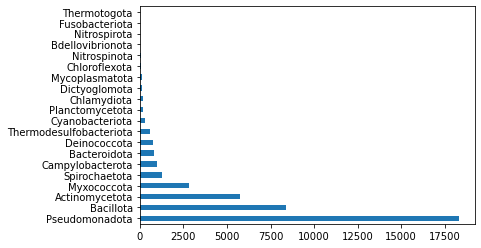

In [186]:
bacterias.phylum.value_counts().plot(kind='barh')

<AxesSubplot:>

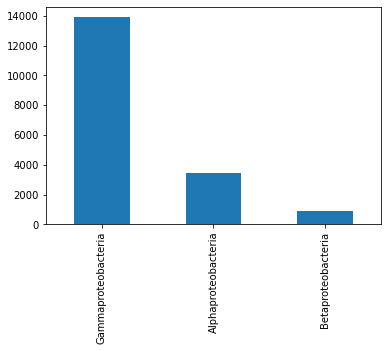

In [190]:
bacterias[bacterias.phylum == 'Pseudomonadota']['class'].value_counts().plot(kind='bar')

In [192]:
bacterias[bacterias['class'] == 'Gammaproteobacteria'].family.value_counts().plot()

Enterobacteriaceae        6760
Vibrionaceae              2494
Pseudomonadaceae          1663
Pasteurellaceae            599
Yersiniaceae               505
Francisellaceae            367
Xanthomonadaceae           278
Shewanellaceae             252
Moraxellaceae              166
Erwiniaceae                145
Thiotrichaceae             106
Morganellaceae             105
Pectobacteriaceae          100
Legionellaceae              89
Pseudoalteromonadaceae      58
Piscirickettsiaceae         53
Coxiellaceae                49
Cellvibrionaceae            46
Bruguierivoracaceae         32
Cardiobacteriaceae          11
Halomonadaceae               1
Name: family, dtype: int64

In [194]:
data.to_csv("../../data/GEOData/GSMs_md_suppl_class.tsv", sep="\t", header=True, index=False)
gsms.to_csv("../../data/GEOData/GSMs_lineage_Ex.tsv", sep='\t', header=True, index=False)


# 9 de noviembre


To do:
- Plotear de manera recursiva las clasificaciones bacterianas más representadas
- Recuperar los taxon ids y agregarlos al dataframe gsms
- Recuperar los GSMs de GSM GEO metadata
    - Plotear distribución de canales

- Propuesta para el código de descarga
- Revisar normalización
- Hacer versión final de plots para el perspective


## Plotear de manera recursiva las clasificaciones bacterianas más representadas

## Recuperar taxon IDs

In [131]:
r = pd.read_csv("../../results/2311_Nov/231109TxIdReco/recovered_lineages.tsv", sep='\t', index_col="Unnamed: 0")


In [132]:
r

,TaxId,no rank,superkingdom,phylum,class,order,family,genus,species group,species,...,subkingdom,subphylum,subclass,serogroup,subspecies,strain,subfamily,tribe,subtribe,serotype
0,1295141,cellular organisms,Bacteria,Pseudomonadota,Gammaproteobacteria,Pseudomonadales,Pseudomonadaceae,Pseudomonas,Pseudomonas fluorescens group,Pseudomonas veronii,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,420662,cellular organisms,Bacteria,Pseudomonadota,Betaproteobacteria,Burkholderiales,Sphaerotilaceae,Methylibium,NaN,Methylibium petroleiphilum,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,502779,Onygenales incertae sedis,Eukaryota,Ascomycota,Eurotiomycetes,Onygenales,NaN,Paracoccidioides,NaN,Paracoccidioides lutzii,...,Dikarya,Pezizomycotina,Eurotiomycetidae,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,183190,cellular organisms,Bacteria,Pseudomonadota,Gammaproteobacteria,Xanthomonadales,Xanthomonadaceae,Xylella,NaN,Xylella fastidiosa,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,90410,NaN,Viruses,Uroviricota,Caudoviricetes,NaN,Aliceevansviridae,Moineauvirus,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,405955,cellular organisms,Bacteria,Pseudomonadota,Gammaproteobacteria,Enterobacterales,Enterobacteriaceae,Escherichia,NaN,Escherichia coli,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,243277,Vibrio cholerae O1 biovar El Tor,Bacteria,Pseudomonadota,Gammaproteobacteria,Vibrionales,Vibrionaceae,Vibrio,NaN,Vibrio cholerae,...,NaN,NaN,NaN,Vibrio cholerae O1,NaN,NaN,NaN,NaN,NaN,NaN
7,272624,cellular organisms,Bacteria,Pseudomonadota,Gammaproteobacteria,Legionellales,Legionellaceae,Legionella,NaN,Legionella pneumophila,...,NaN,NaN,NaN,NaN,Legionella pneumophila subsp. pneumophila,NaN,NaN,NaN,NaN,NaN
8,1279007,cellular organisms,Bacteria,Pseudomonadota,Gammaproteobacteria,Pseudomonadales,Pseudomonadaceae,Pseudomonas,Pseudomonas aeruginosa group,Pseudomonas aeruginosa,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,436308,cellular organisms,Archaea,Nitrososphaerota,Nitrososphaeria,Nitrosopumilales,Nitrosopumilaceae,Nitrosopumilus,NaN,Nitrosopumilus maritimus,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [133]:
vir = pd.DataFrame.from_dict({"TaxId" : [10239], "superkingdom" : ["Viruses"]})

In [134]:
r = pd.concat([r, vir])

In [103]:
c = pd.DataFrame.from_dict({"taxon":recovered.keys(), "TaxId":recovered.values()})


In [104]:
c.TaxId = c.TaxId.astype("int64")
new = pd.merge(c,r)

In [105]:
taxon = pd.read_csv("../../results/2310_Oct/231030GSMsMeta/LineageEx/allTaxonLineage_3.tsv", sep='\t').rename(columns={"Unnamed: 0":"taxon"})

In [135]:
all = pd.concat([taxon, r])

In [136]:
all.shape

(1814, 37)

In [137]:
all.to_csv("../../data/GEOData/all_GEO_lineages.csv", index=False)

In [85]:
print(data.shape)
gsms = data.merge(all)

(1715065, 17)


In [86]:
gsms.shape

(1706604, 53)

In [89]:
spur = set(data.taxon) - set(gsms.taxon)

In [100]:
{i for i in spur if not ';' in i and not ' x ' in i}

set()

In [101]:
gsms

,Id,Accession,GPL,GSE,taxon,PDAT,suppFile,FTPLink,technology,distribution,...,species subgroup,serogroup,parvorder,subspecies,section,subcohort,strain,biotype,subsection,serotype
0,301115610.0,GSM1115610,GPL16969,45801,Drosophila serrata,2013/11/05,PAIR,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM1115...,in situ oligonucleotide,custom-commercial,...,montium subgroup,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,301115599.0,GSM1115599,GPL16969,45801,Drosophila serrata,2013/11/05,PAIR,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM1115...,in situ oligonucleotide,custom-commercial,...,montium subgroup,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,301115636.0,GSM1115636,GPL16969,45801,Drosophila serrata,2013/11/05,PAIR,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM1115...,in situ oligonucleotide,custom-commercial,...,montium subgroup,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,301115743.0,GSM1115743,GPL16969,45801,Drosophila serrata,2013/11/05,PAIR,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM1115...,in situ oligonucleotide,custom-commercial,...,montium subgroup,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,302411571.0,GSM2411571,GPL16969,90733,Drosophila serrata,2017/01/04,PAIR,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM2411...,in situ oligonucleotide,custom-commercial,...,montium subgroup,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1706599,301714042.0,GSM1714042,GPL20577,69963,Escherichia coli BL21,2015/06/18,GPR,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM1714...,in situ oligonucleotide,custom-commercial,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1706600,300050839.0,GSM50839,GPL2036,2648,Lilium longiflorum,2006/03/23,NaN,NaN,spotted DNA/cDNA,non-commercial,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1706601,301305854.0,GSM1305854,GPL18161,54012,Neochlamydia sp. S13,2014/12/31,TXT,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM1305...,in situ oligonucleotide,custom-commercial,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1706602,301305855.0,GSM1305855,GPL18161,54012,Neochlamydia sp. S13,2014/12/31,TXT,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM1305...,in situ oligonucleotide,custom-commercial,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [102]:
gsms.to_csv("../../data/GEOData/GSMs_lineage_Ex_filt.csv", index=False)

In [103]:
gsms.columns

Index(['Id', 'Accession', 'GPL', 'GSE', 'taxon', 'PDAT', 'suppFile', 'FTPLink',
       'technology', 'distribution', 'organism', 'taxid', 'manufacturer',
       'supplementary_file', 'data_row_count', 'Flag', 'SupplCount', 'TaxId',
       'no rank', 'superkingdom', 'kingdom', 'phylum', 'subphylum', 'clade',
       'class', 'order', 'family', 'tribe', 'genus', 'subclass', 'superfamily',
       'superclass', 'infraclass', 'cohort', 'suborder', 'infraorder',
       'subfamily', 'species', 'subtribe', 'subkingdom', 'subgenus',
       'superorder', 'species group', 'species subgroup', 'serogroup',
       'parvorder', 'subspecies', 'section', 'subcohort', 'strain', 'biotype',
       'subsection', 'serotype'],
      dtype='object')

In [2]:
import pandas as pd
gsms = pd.read_csv("../../data/GEOData/GSMs_lineage_Ex_filt.csv")

/export/apps/bioconda/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (11,13,17,27,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,52) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


<AxesSubplot:>

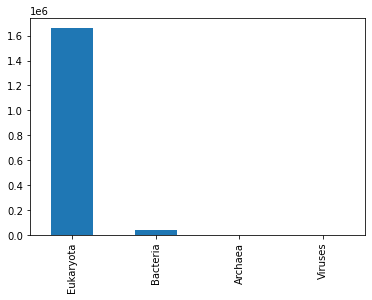

In [4]:
gsms.superkingdom.value_counts().plot(kind="bar")

<AxesSubplot:>

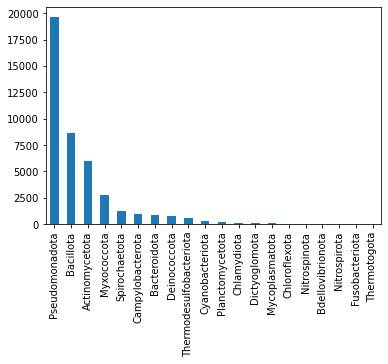

In [7]:
gsms[gsms.superkingdom == "Bacteria"].phylum.value_counts().plot(kind="bar")

In [ ]:
gsms[gsms.superkingdom == "Bacteria"].phylum.value_counts().plot(kind="bar")

<AxesSubplot:>

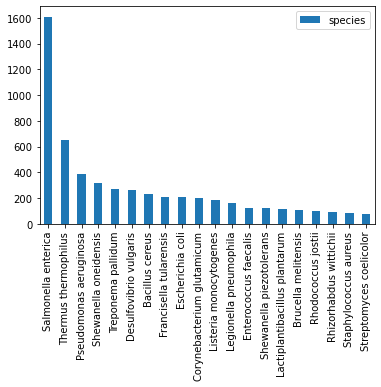

In [10]:
pd.DataFrame(gsms[gsms.superkingdom == "Bacteria"].species.value_counts()).head(n=20).plot(kind="bar")

<AxesSubplot:>

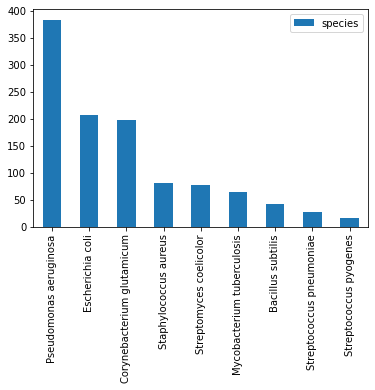

In [12]:
abasy = ["Mycobacterium tuberculosis",
"Bacillus subtilis",
"Corynebacterium glutamicum",
"Escherichia coli",
"Streptomyces coelicolor",
"Pseudomonas aeruginosa",
"Staphylococcus aureus",
"Streptococcus pyogenes",
"Streptococcus pneumoniae"]

pd.DataFrame(gsms[(gsms.superkingdom == "Bacteria") & gsms.species.isin(abasy)].species.value_counts()).head(n=20).plot(kind="bar")

In [18]:
set(gsms[gsms.species.isin(abasy)].technology)

{'in situ oligonucleotide', 'spotted DNA/cDNA', 'spotted oligonucleotide'}

In [156]:
gsms[gsms.species.isin(abasy)].shape

(574, 50)

In [21]:
len(gsms.Accession.unique())

1706306

In [52]:
set(gsms[~gsms.species.isna() & gsms.species.str.contains("Escherichia coli", case=False)].Accession)

207

In [28]:
raw = pd.read_csv("../../results/2310_Oct/231004BigTest/run10Locote/raw_231004Locote.tsv", sep='\t')

In [55]:
gsms[gsms.GSE == '80002'] #GSE80002

,Id,Accession,GPL,GSE,taxon,PDAT,suppFile,FTPLink,technology,distribution,...,species subgroup,serogroup,parvorder,subspecies,section,subcohort,strain,biotype,subsection,serotype
1449932,302109848.0,GSM2109848,GPL3154,80002,Escherichia coli str. K-12 substr. MG1655,2016/04/06,"CEL, CHP",ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM2109...,in situ oligonucleotide,commercial,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1449937,302109784.0,GSM2109784,GPL3154,80002,Escherichia coli str. K-12 substr. MG1655,2016/04/06,"CEL, CHP",ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM2109...,in situ oligonucleotide,commercial,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1449938,302109788.0,GSM2109788,GPL3154,80002,Escherichia coli str. K-12 substr. MG1655,2016/04/06,"CEL, CHP",ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM2109...,in situ oligonucleotide,commercial,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1449939,302109795.0,GSM2109795,GPL3154,80002,Escherichia coli str. K-12 substr. MG1655,2016/04/06,"CEL, CHP",ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM2109...,in situ oligonucleotide,commercial,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1449943,302109780.0,GSM2109780,GPL3154,80002,Escherichia coli str. K-12 substr. MG1655,2016/04/06,"CEL, CHP",ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM2109...,in situ oligonucleotide,commercial,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1450230,302109806.0,GSM2109806,GPL3154,80002,Escherichia coli str. K-12 substr. MG1655,2016/04/06,"CEL, CHP",ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM2109...,in situ oligonucleotide,commercial,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1450231,302109819.0,GSM2109819,GPL3154,80002,Escherichia coli str. K-12 substr. MG1655,2016/04/06,"CEL, CHP",ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM2109...,in situ oligonucleotide,commercial,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1450237,302109846.0,GSM2109846,GPL3154,80002,Escherichia coli str. K-12 substr. MG1655,2016/04/06,"CEL, CHP",ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM2109...,in situ oligonucleotide,commercial,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1450238,302109796.0,GSM2109796,GPL3154,80002,Escherichia coli str. K-12 substr. MG1655,2016/04/06,"CEL, CHP",ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM2109...,in situ oligonucleotide,commercial,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [62]:
len(set(gsms.Accession) & set(raw.GSM_geo_accession))/len(set(raw.GSM_geo_accession))

0.9576560720571488

In [58]:
allgsms = pd.read_csv("../../data/GEOData/allGSMsMetadata.tsv", sep='\t')

/export/apps/bioconda/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (2,7,11,12,13,14,15,21,22,23,24,25,29) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [61]:
len(set(allgsms.Accession) & set(raw.GSM_geo_accession))/len(set(raw.GSM_geo_accession))

1.0

In [59]:
allgsms[allgsms.Accession == 'GSM2109791']

,Unnamed: 0,Item,Id,Accession,GDS,title,summary,GPL,GSE,taxon,...,ExtRelations,n_samples,SeriesTitle,PlatformTitle,PlatformTaxa,SamplesTaxa,PubMedIds,Projects,FTPLink,GEO2R
1616471,26687.0,[],302109791,GSM2109791,NaN,WT_15 (Low Dilution) Rep3,control strain w/o hypoxanthine 15 min at low ...,3154,80002,Escherichia coli str. K-12 substr. MG1655,...,[],0.0,NaN,NaN,NaN,NaN,[],[],ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM2109...,NaN


In [70]:
gsms[gsms.Accession == 'GSM2109791'].species

1450218    NaN
Name: species, dtype: object

In [69]:
len(set(gsms[(~gsms.species.isna()) & gsms.species.str.contains("Escherichia coli", case=False)].Accession))

207

In [67]:
set(raw[raw.GSM_organism_ch1.str.contains('Escherichia coli')].GSM_geo_accession).difference(set(gsms[(~gsms.species.isna()) & gsms.species.str.contains("Escherichia coli", case=False)].Accession))

ValueError: Cannot mask with non-boolean array containing NA / NaN values

In [53]:
set(raw[raw.GSM_organism_ch1.str.contains('Escherichia coli')].GSM_geo_accession) - set(gsms[~gsms.species.isna() & gsms.species.str.contains("Escherichia coli", case=False)].Accession)

{'GSM2109791',
 'GSM2335775',
 'GSM1010203',
 'GSM602864',
 'GSM2138445',
 'GSM1155596',
 'GSM337452',
 'GSM2473483',
 'GSM509009',
 'GSM993813',
 'GSM443990',
 'GSM2109863',
 'GSM337408',
 'GSM543455',
 'GSM1123934',
 'GSM867015',
 'GSM509040',
 'GSM3243121',
 'GSM337430',
 'GSM2649430',
 'GSM1535873',
 'GSM432657',
 'GSM867008',
 'GSM337423',
 'GSM993818',
 'GSM1845333',
 'GSM6245896',
 'GSM4285732',
 'GSM576639',
 'GSM509045',
 'GSM1901145',
 'GSM602874',
 'GSM1317879',
 'GSM1375011',
 'GSM1010202',
 'GSM1654946',
 'GSM622789',
 'GSM333086',
 'GSM508953',
 'GSM727647',
 'GSM510327',
 'GSM2284709',
 'GSM1845346',
 'GSM510325',
 'GSM2109859',
 'GSM2109821',
 'GSM333079',
 'GSM509004',
 'GSM3243092',
 'GSM4285755',
 'GSM432683',
 'GSM310610',
 'GSM1334769',
 'GSM1845324',
 'GSM2464579',
 'GSM1155624',
 'GSM752489',
 'GSM861318',
 'GSM789205',
 'GSM6481085',
 'GSM1010200',
 'GSM1356336',
 'GSM337442',
 'GSM279035',
 'GSM1375008',
 'GSM993823',
 'GSM611684',
 'GSM508970',
 'GSM936392',
 

In [14]:
gsms[gsms.species == 'Pseudomonas aeruginosa']

,Id,Accession,GPL,GSE,taxon,PDAT,suppFile,FTPLink,technology,distribution,...,species subgroup,serogroup,parvorder,subspecies,section,subcohort,strain,biotype,subsection,serotype
1629722,300838208.0,GSM838208,GPL84,33871,Pseudomonas aeruginosa PAO1,2013/12/13,CEL,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM838n...,in situ oligonucleotide,commercial,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1629723,301267104.0,GSM1267104,GPL84,52445,Pseudomonas aeruginosa PAO1,2013/12/10,CEL,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM1267...,in situ oligonucleotide,commercial,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1629724,301958033.0,GSM1958033,GPL84,75502,Pseudomonas aeruginosa PAO1,2015/12/09,"CEL, CHP",ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM1958...,in situ oligonucleotide,commercial,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1629725,300738262.0,GSM738262,GPL84,29789,Pseudomonas aeruginosa PAO1,2011/10/06,CEL,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM738n...,in situ oligonucleotide,commercial,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1629726,300663168.0,GSM663168,GPL84,26932,Pseudomonas aeruginosa PAO1,2011/11/29,"CEL, CHP",ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM663n...,in situ oligonucleotide,commercial,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1705373,302112991.0,GSM2112991,GPL21703,80117,Pseudomonas aeruginosa PA1,2016/10/19,TXT,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM2112...,in situ oligonucleotide,custom-commercial,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1705374,302112993.0,GSM2112993,GPL21703,80117,Pseudomonas aeruginosa PA1,2016/10/19,TXT,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM2112...,in situ oligonucleotide,custom-commercial,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1705375,302112995.0,GSM2112995,GPL21703,80117,Pseudomonas aeruginosa PA1,2016/10/19,TXT,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM2112...,in situ oligonucleotide,custom-commercial,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1705376,302112994.0,GSM2112994,GPL21703,80117,Pseudomonas aeruginosa PA1,2016/10/19,TXT,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM2112...,in situ oligonucleotide,custom-commercial,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
gsms.columns

Index(['Id', 'Accession', 'GPL', 'GSE', 'taxon', 'PDAT', 'suppFile', 'FTPLink',
       'technology', 'distribution', 'organism', 'taxid', 'manufacturer',
       'supplementary_file', 'data_row_count', 'Flag', 'SupplCount', 'TaxId',
       'no rank', 'superkingdom', 'kingdom', 'phylum', 'subphylum', 'clade',
       'class', 'order', 'family', 'tribe', 'genus', 'subclass', 'superfamily',
       'superclass', 'infraclass', 'cohort', 'suborder', 'infraorder',
       'subfamily', 'species', 'subtribe', 'subkingdom', 'subgenus',
       'superorder', 'species group', 'species subgroup', 'serogroup',
       'parvorder', 'subspecies', 'section', 'subcohort', 'strain', 'biotype',
       'subsection', 'serotype'],
      dtype='object')